# Parameter sweeps - Analysis

This notebook reads the output of `07_cluster_stats_sweeps.ipynb` and generates several plots as part of the analysis of results.

## Configuration

We need to define the name (or label) of the parameter sweeps experiments, as well as the path to access the results.

In [1]:
LABEL          = 'sweeps-lambda-b'
RESULTS_PATH   = '../results'
PARAMETER_NAME = 'lambda'

And we have some standard packages to read the files and analize the data.

In [2]:
import os
import numpy as np
import pandas as pd
import seaborn
from matplotlib import pyplot as plt
%matplotlib inline

## Input files and observation data

Let's read all the experiment data and save it into a `results` dataframe.

In [3]:
# Locate output directory
results_dir = os.path.join( os.path.abspath(RESULTS_PATH), LABEL )
if os.path.exists( results_dir ):
    print( '... results directory found.' )
else:
    print( '... results directory not found.' )
    raise

# Identify the relevant experiment result files
output_prefix = results_dir + '/' + LABEL
output_files = [ filename for filename in os.listdir(results_dir) if filename.startswith(LABEL + '-parameter-sweep-results--experiment-') ]
print( '... ', len(output_files), ' result files found' )

# Load data into dataframe
results = pd.DataFrame()
columns_to_keep = [ 'reff', 'sampling_rate', 'cutoff', 'n_clusters',
       'cluster_size_mean', 'cluster_size_cov', 'weighted_cluster_size_mean',
       'weighted_cluster_size_cov', 'sim_time', 'mean_partner',
       'acts_per_day', 'lambda', 'removal_rate', 'sampling_delay',
       'execution_time', 'samplesize', 'sampled_individuals', 'cluster_labels',
       'experiment_id']
empty_files = 0
for i, file in enumerate(output_files):
    if (i%10 == 0):
        print( '... processing file ', i+1, '/', len(output_files) )
    
    try:
        results_this_file_raw = pd.read_csv( results_dir + '/' + file )     \
                                  .loc[:,columns_to_keep]

        for index, row in results_this_file_raw.iterrows():

            cluster_labels = row['cluster_labels'].replace('[','').replace(']','').replace(' ','').split(',')
            
            
            n_population = len( cluster_labels )
            n_nan = cluster_labels.count('nan')

            results_this_file_raw.loc[index, 'percentage_samples_clustered'] = (1 - n_nan/n_population) *100
        
        
        results_this_file = results_this_file_raw.groupby( ['sampling_rate','cutoff'] )    \
                                                 .mean(numeric_only=True)                                   \
                                                 .reset_index()
        
        results = pd.concat( [results, results_this_file], ignore_index=True )
    except:
        #print('EmptyDataError: No columns to parse from file: ', results_dir + '/' + file, ' is empty')
        empty_files += 1

print( '... ', len(output_files), ' files processed' )
if empty_files > 0:
    print('... found ', empty_files, ' empty files (', empty_files/len(output_files)*100, '%)' )   

... results directory found.
...  14  result files found
... processing file  1 / 14
... processing file  11 / 14
...  14  files processed
... found  6  empty files ( 42.857142857142854 %)


...  47  population summary files found
... analyzing file:  /home/rnunez/work/clustersim/dev/20230720-with-phylomodels/results/sweeps-lambda-b/sweeps-lambda-b/sweeps-lambda-b--samplesize_250--sim_time_7300--mean_partner_0_6--acts_per_day_0_3--lambda_0_0005--removal_rate_0_001--sampling_delay_180--seed_0--population_summary.csv
... average number of infections per infected person:  2.2666666666666666


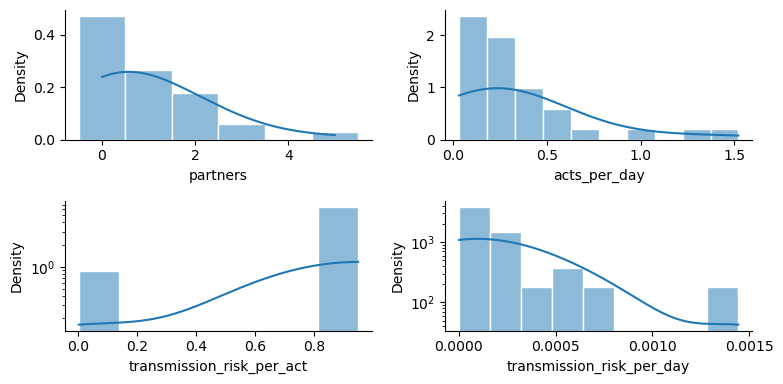

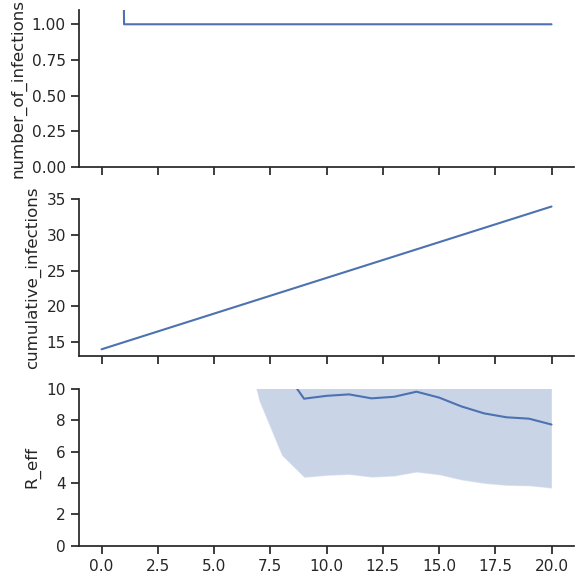

In [4]:
# Let's get also some timeseries

# Identify the relevant experiment result files
output_prefix = results_dir + '/' + LABEL
output_files = [ filename for filename in os.listdir(results_dir) if filename.endswith('-population_summary.csv') ]
print( '... ', len(output_files), ' population summary files found' )

def plot_timeseries( filename ):

    import math
    import epyestim
    from scipy.stats import gamma

    # Load file
    data_raw = pd.read_csv( filename )
    data_raw['source'   ] = data_raw['source'   ].astype('int').astype('str')
    data_raw['recipient'] = data_raw['recipient'].astype('int').astype('str')

    # Check parameter values
    population_params = [ 'partners', 'acts_per_day', 'transmission_risk_per_act', 'transmission_risk_per_day' ]

    ncols = 2
    nrows = math.ceil( len(population_params)/ncols )
    fig, axs = plt.subplots( nrows, ncols, figsize=(4*ncols, 2*nrows) )
    seaborn.set_theme( style='ticks' )

    for i, param_name in enumerate(population_params):
        discrete_param = True if param_name in ['partners'] else False
        logy = True if param_name in ['transmission_risk_per_act', 'transmission_risk_per_day'] else False
        seaborn.histplot( data_raw[param_name],
                          stat     = 'density',
                          discrete = discrete_param,
                          kde      = True,
                          log_scale = (False,logy),
                          kde_kws  = {'bw_adjust': 2},
                          ax       = axs[int(i/ncols), i%ncols]
                        )
        seaborn.despine()
    fig.tight_layout()                      


    # Epidemic trajectory
    infection_count = pd.DataFrame()
    infection_count['number_of_infections' ] = data_raw.groupby('infectionTime').count().iloc[:,0]
    infection_count['cumulative_infections'] = infection_count['number_of_infections'].cumsum()
    

    # Reff
    from find_clusters import get_reff
    reff, reff_df = get_reff( data_raw )
    infection_count['R_eff'   ] = reff_df['R_mean'].values 
    infection_count['R_q0.025'] = reff_df['Q0.025'].values 
    infection_count['R_q0.975'] = reff_df['Q0.975'].values 

    infections_per_source = data_raw.groupby( ['source'] ).count()
    print( '... average number of infections per infected person: ', infections_per_source.mean().iloc[0] )
    
    # Draw plots
    fig_trj, axs_trj = plt.subplots( 3, 1, figsize=(6, 6), sharex=True )
    x_trj = range(len(infection_count))

    seaborn.set_style( 'whitegrid' )

    seaborn.lineplot( infection_count,
                      x  = x_trj,
                      y  = 'number_of_infections',
                      ax = axs_trj[0]
                     )
    ax = axs_trj[0].set_ylim( [0, 1.1*infection_count['number_of_infections'].values[1:].max()] )
    seaborn.despine()

    seaborn.lineplot( infection_count,
                      x  = x_trj,
                      y  = 'cumulative_infections',
                      ax = axs_trj[1]
                     )
    seaborn.despine()

    seaborn.lineplot( infection_count,
                      x  = x_trj,
                      y  = 'R_eff',
                      ax = axs_trj[2]
                     )
    axs_trj[2].fill_between( x_trj, 
                         infection_count['R_q0.025'],
                         infection_count['R_q0.975'],
                         alpha = 0.3
                       )
    ax = axs_trj[2].set_ylim( [0, 10] )

    seaborn.despine()

    
    fig_trj.tight_layout()

    return

file_to_plot = results_dir + '/' + output_files[0] 
print('... analyzing file: ', output_prefix + '/' + output_files[0])
plot_timeseries( file_to_plot )

In [5]:
results

,sampling_rate,cutoff,reff,n_clusters,cluster_size_mean,cluster_size_cov,weighted_cluster_size_mean,weighted_cluster_size_cov,sim_time,mean_partner,acts_per_day,lambda,removal_rate,sampling_delay,execution_time,samplesize,experiment_id,percentage_samples_clustered
0,0.05,730,4.563866,1.6,2.700000,0.140147,2.873016,0.261051,7300.0,0.6,0.3,0.0015,0.001,180.0,103.476446,250.0,4.0,41.492997
1,0.05,1825,4.563866,1.6,3.200000,0.100000,3.400000,0.128062,7300.0,0.6,0.3,0.0015,0.001,180.0,103.476446,250.0,4.0,48.336134
2,0.05,2555,4.563866,1.4,5.700000,0.138462,6.323077,0.136971,7300.0,0.6,0.3,0.0015,0.001,180.0,103.476446,250.0,4.0,68.722689
3,0.10,730,4.563866,2.6,3.150000,0.308518,3.782185,0.465087,7300.0,0.6,0.3,0.0015,0.001,180.0,103.476446,250.0,4.0,40.080065
4,0.10,1825,4.563866,2.8,5.383333,0.526697,8.143172,0.640054,7300.0,0.6,0.3,0.0015,0.001,180.0,103.476446,250.0,4.0,71.127597
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
475,0.95,1825,2.239885,36.8,23.996305,3.149409,282.584051,0.936365,7300.0,0.6,0.3,0.0022,0.001,180.0,169.362195,250.0,7.0,98.475661
476,0.95,2555,2.239885,13.6,76.023601,2.580436,559.537342,0.886505,7300.0,0.6,0.3,0.0022,0.001,180.0,169.362195,250.0,7.0,99.735463
477,1.00,730,2.239885,138.0,6.118741,2.060085,32.290321,0.950200,7300.0,0.6,0.3,0.0022,0.001,180.0,169.362195,250.0,7.0,91.478602
478,1.00,1825,2.239885,38.2,23.955711,3.249112,300.072715,0.939746,7300.0,0.6,0.3,0.0022,0.001,180.0,169.362195,250.0,7.0,98.729810


And here is the observation data:

In [6]:
pangea_data = pd.DataFrame( [ [ 'HIVDRD, UK'         , 'firebrick' , 3.4 , 1.5 , 11   , 2   , 0.7 , 1.5    ],
                              [ 'PopART, Zambia'     , 'blue'      , 2.27, 0.29,  2.46, 0.39, 0.16, 3.19   ],
                              [ 'Rakai, Uganda'      , 'dodgerblue', 2.33, 0.30,  2.55, 0.36, 0.23, 3.27   ],
                              [ 'Ya Tsie, Botswana'  , 'teal'      , 2.07, 0.12,  2.10, 0.14, 0.02, 5.15   ],
                              [ 'ATHENA cohort (MSM)', 'orangered' , 4.58, 1.63, 16.78,	1.46, 0.33,	np.nan ],
                              [ 'ATHENA cohort (HET)', 'red'       , 2.67, 0.72,  4.04,	0.96, 0.19, np.nan ]
                             ],
                             columns = [ 'location',
                                         'color',
                                         'cluster size (mean)',
                                         'cluster size (CoV)',
                                         'weighted cluster size (mean)',
                                         'weighted cluster size (CoV)',
                                         'Gini coefficient', 
                                         'R0'
                                        ]
                           )

## Execution time

Let's check how long it takes to finish one simulation. This is based on the execution time of the experiments that were successfully completed, i.e., experiments that timed-out are not included/counted here. 

Text(0, 0.5, 'Percent (cumulative)')

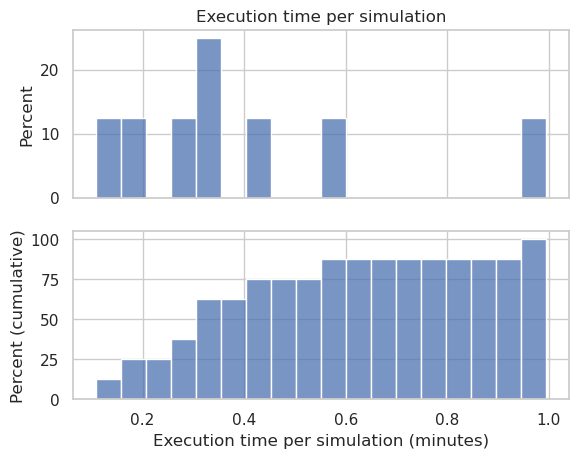

In [7]:
results['Execution time per simulation (minutes)'] = results['execution_time']/5/60

fig_time, axs_time = plt.subplots( 2, 1, sharex=True )

seaborn.histplot( results, 
                  x    = 'Execution time per simulation (minutes)', 
                  stat = 'percent',
                  ax   = axs_time[0],
                  cumulative = False,
                 )
axs_time[0].set_title( 'Execution time per simulation' )
seaborn.histplot( results, 
                  x    = 'Execution time per simulation (minutes)', 
                  stat = 'percent',
                  ax   = axs_time[1],
                  cumulative = True 
                 )
axs_time[1].set_ylabel( 'Percent (cumulative)' )

Now let's see how the execution time changes as a function of the simulation parameters

## Clustering metrics

Let's see how things look as a function of sampling rate:

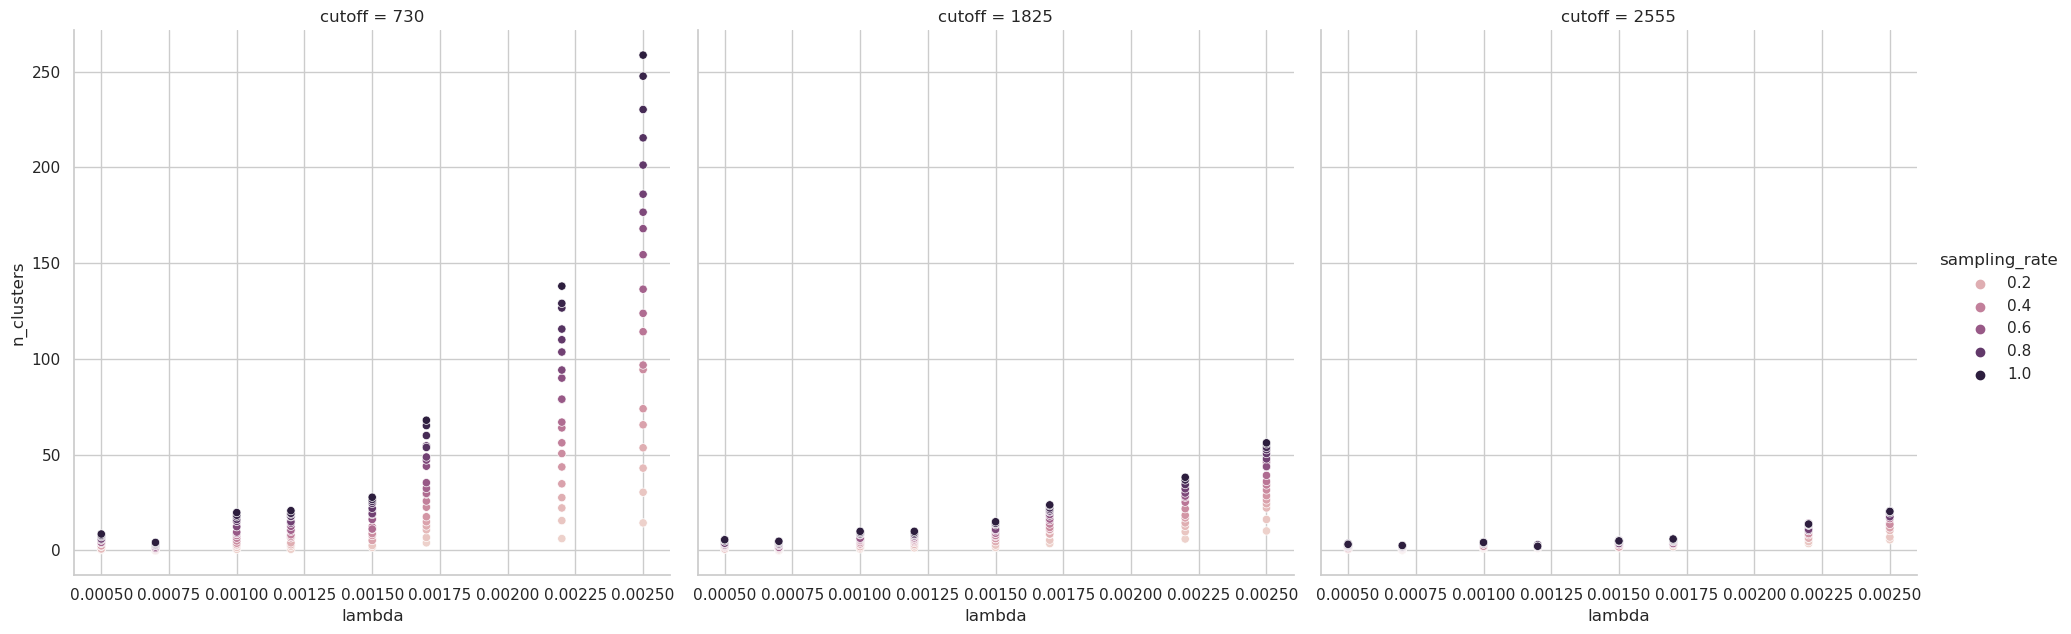

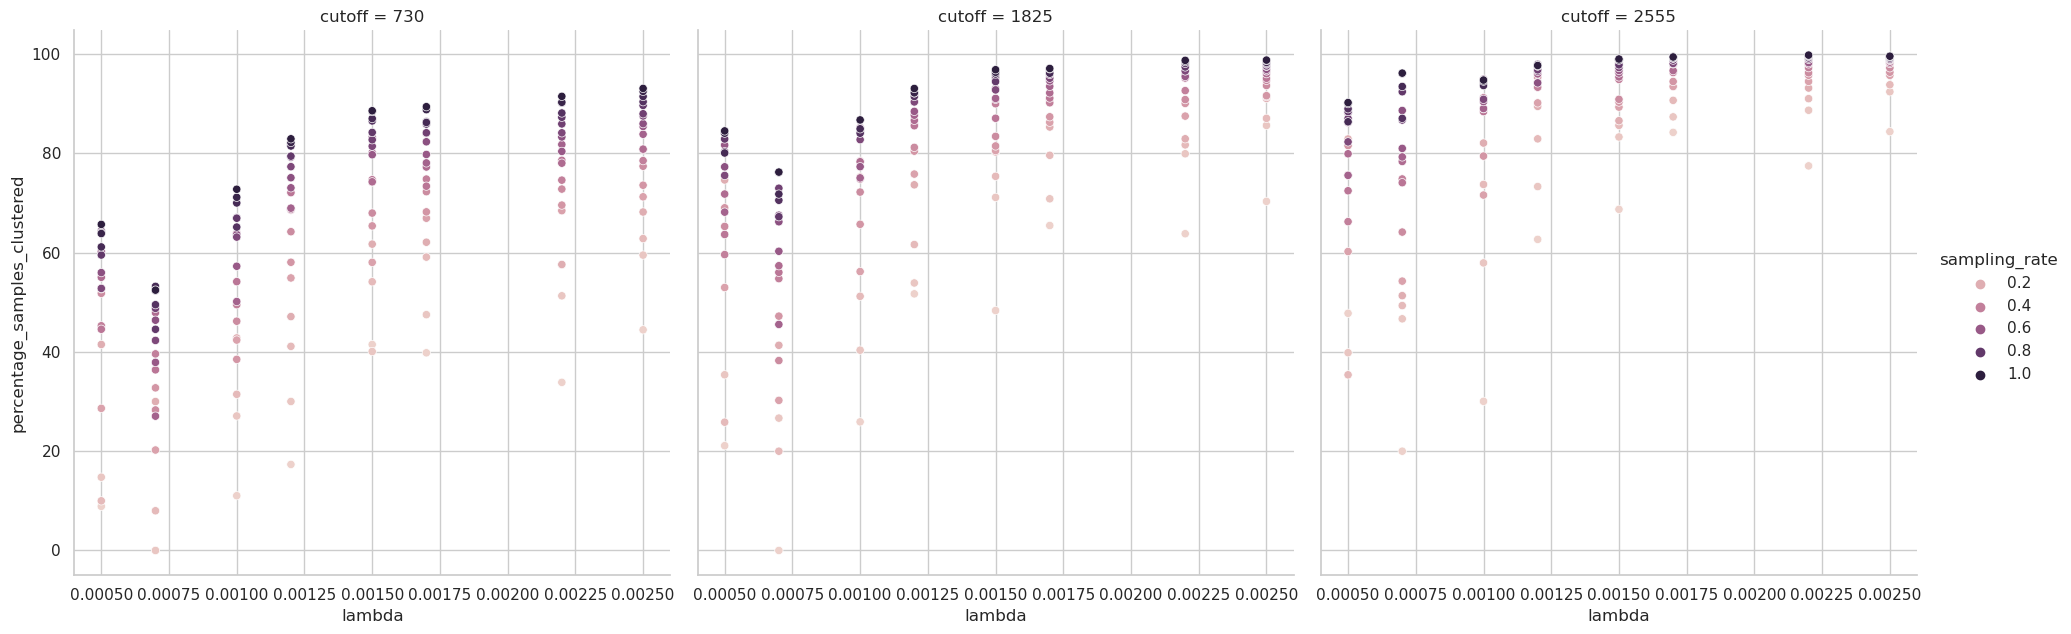

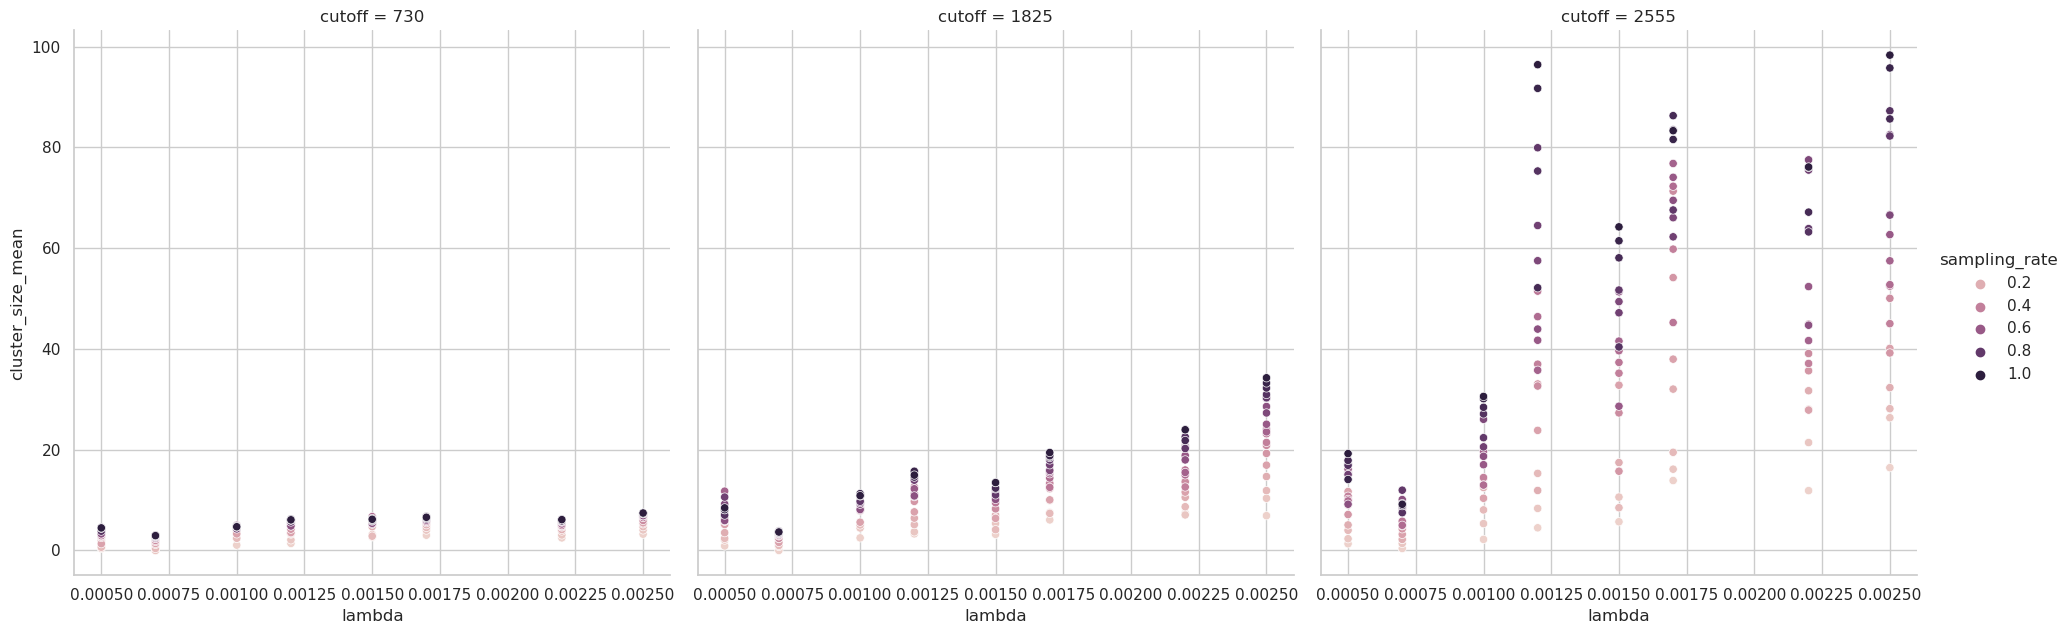

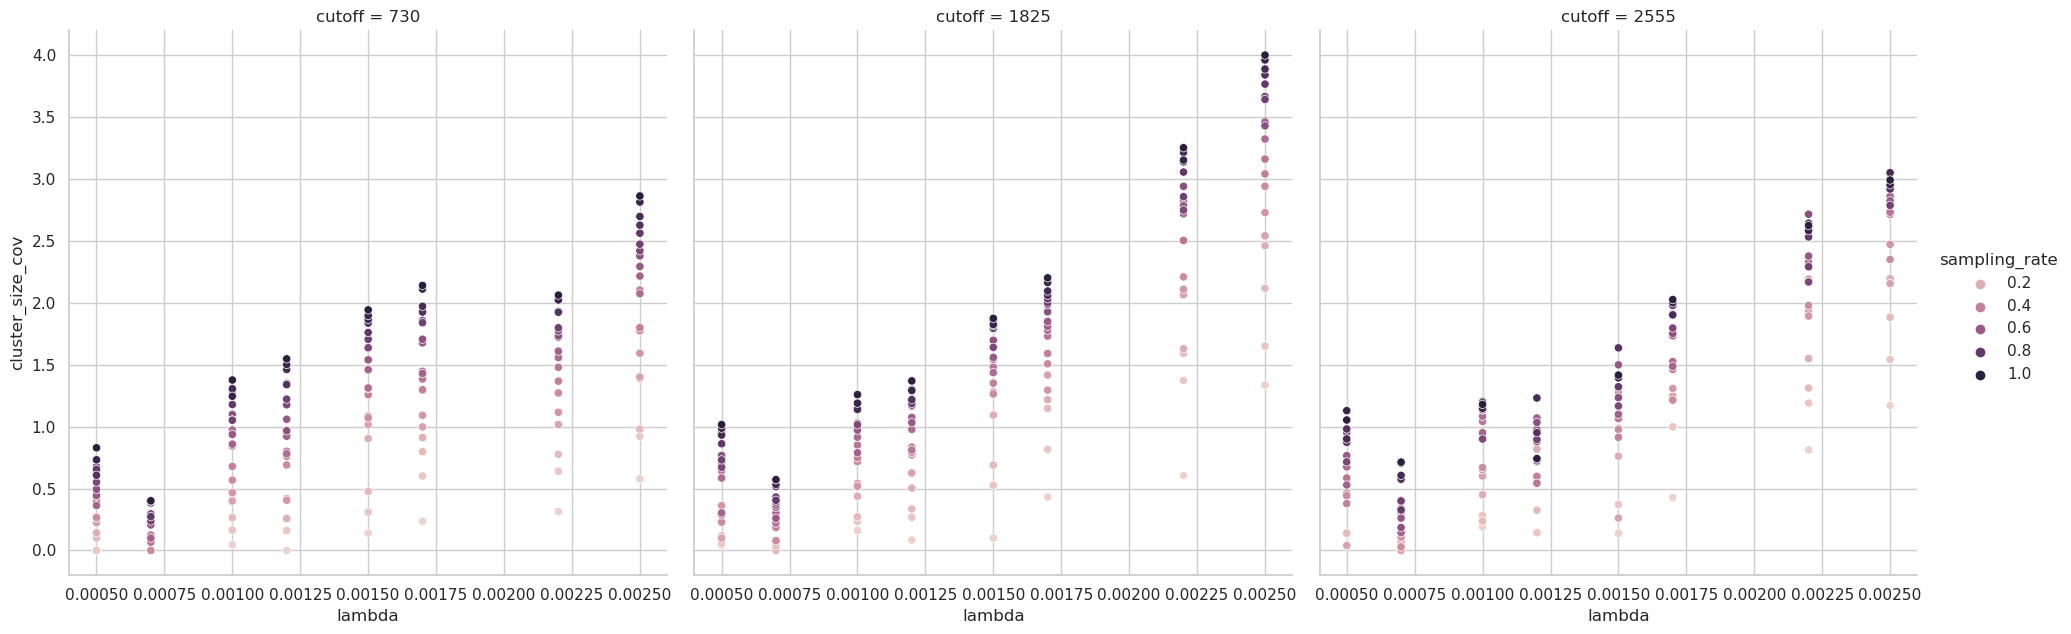

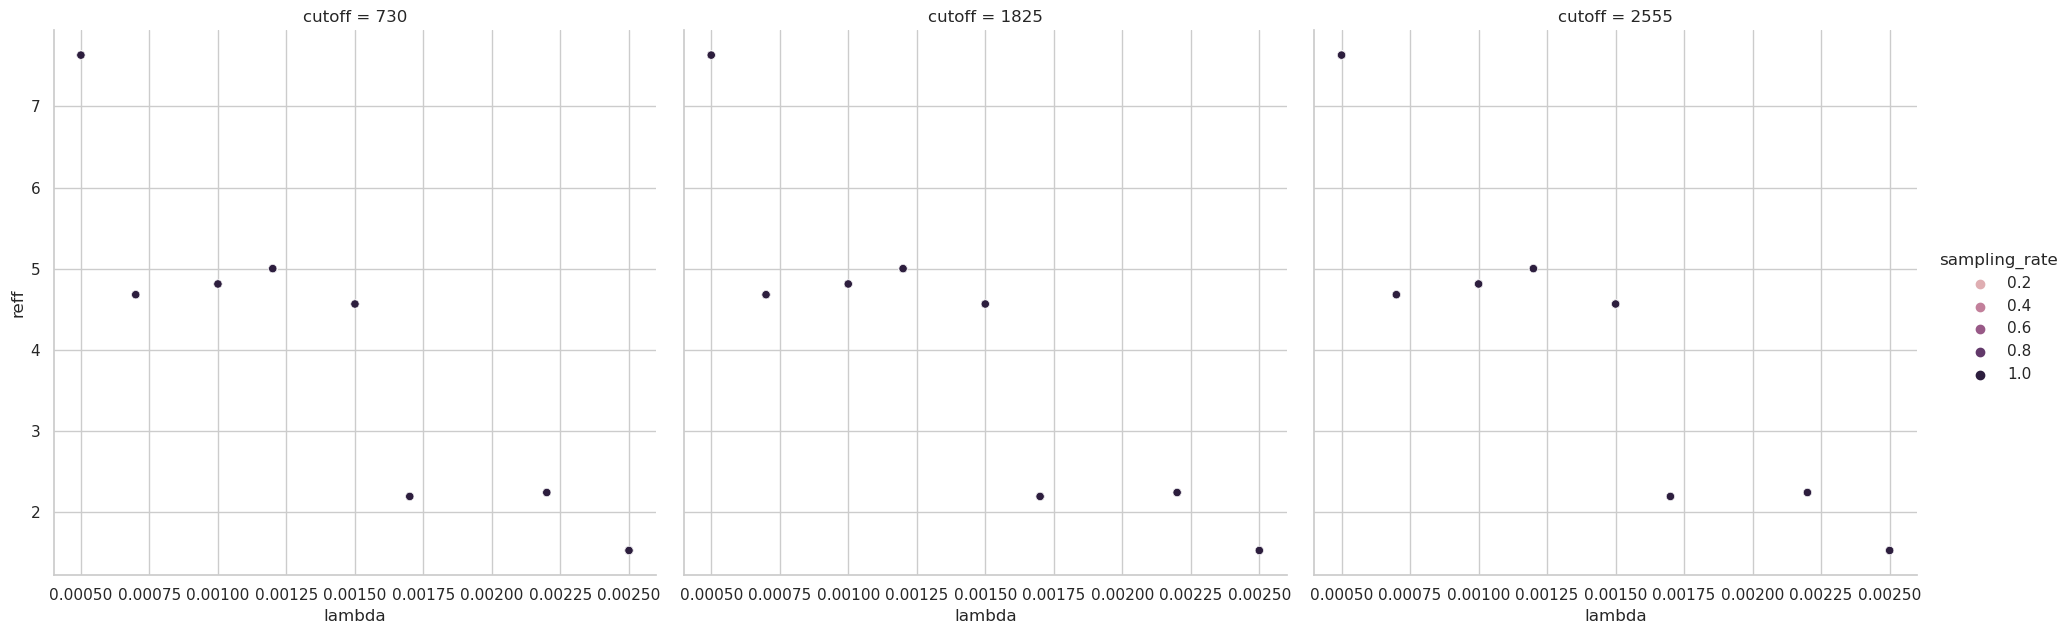

In [10]:
seaborn.relplot( results,
                 x = PARAMETER_NAME,
                 y = 'n_clusters',
                 hue =  'sampling_rate',
                 #size = 'sampling_delay',
                 col = 'cutoff',
                 height = 6.5
                 )

seaborn.relplot( results,
                 x = PARAMETER_NAME,
                 y = 'percentage_samples_clustered',
                 hue =  'sampling_rate',
                 #size = 'sampling_delay',
                 col = 'cutoff',
                 height = 6.5
                 )

seaborn.relplot( results,
                 x = PARAMETER_NAME,
                 y = 'cluster_size_mean',
                 hue =  'sampling_rate',
                 #size = 'sampling_delay',
                 col = 'cutoff',
                 height = 6.5
                 ) 

seaborn.relplot( results,
                 x = PARAMETER_NAME,
                 y = 'cluster_size_cov',
                 hue =  'sampling_rate',
                 #size = 'sampling_delay',
                 col = 'cutoff',
                 height = 6.5
                 )

seaborn.relplot( results,
                 x = PARAMETER_NAME,
                 y = 'reff',
                 hue =  'sampling_rate',
                 #size = 'sampling_delay',
                 col = 'cutoff',
                 height = 6.5
                 )